## Transfer Learning Demo with AlexNet Architecture Using PyTorch

To know details about AlexNet Architecture:

Visit here: https://hackmd.io/@imkushwaha/alexnet

### Mounting Google Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Set Root Directory

In [2]:
import os 
ROOT = "/content/drive/MyDrive/Deep Learning(@ineuron)/PyTorch"
os.chdir(ROOT)

### Required Imports

In [4]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import transforms, datasets, models
import torch.nn.functional as F
from sklearn.metrics import confusion_matrix
from tqdm import tqdm

import urllib.request as request

### Make config class to store all hyper-parameters and data dir

In [5]:
class Config:
  def __init__(self):
    self.ROOT_DATA_DIR = "hymenoptera_data"
    self.EPOCH = 10
    self.BATCH_SIZE = 32
    self.LEARNING_RATE = 0.01
    self.IMAGE_SIZE = (224, 224)
    self.DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
    print(f"This notebook is using device: {self.DEVICE}")
    self.SEED = 2022

  def create_dir(self, dir_path):
    os.makedirs(dir_path, exist_ok=True)
    print(f"{dir_path} directory is created")

config = Config()

This notebook is using device: cuda


### Download data

In [6]:
data_URL = "https://download.pytorch.org/tutorial/hymenoptera_data.zip"

In [7]:
config.create_dir(dir_path=config.ROOT_DATA_DIR)

hymenoptera_data directory is created


In [8]:
data_zip_file = "data.zip"
data_file_path = os.path.join(config.ROOT_DATA_DIR, data_zip_file)

request.urlretrieve(data_URL, data_file_path)

('hymenoptera_data/data.zip', <http.client.HTTPMessage at 0x7fd2ce086dd0>)

### Unzip downloaded file

In [9]:
from zipfile import ZipFile

def unzip_file(source: str, dest: str) -> None:
    print(f"extraction started...")

    with ZipFile(source, "r") as zip_f:
        zip_f.extractall(dest)
    print(f"extracted {source} to {dest}")

In [10]:
unzip_file(data_file_path, config.ROOT_DATA_DIR)

extraction started...
extracted hymenoptera_data/data.zip to hymenoptera_data


### Create data loaders-

In [11]:
from pathlib import Path

In [13]:
train_path = Path("hymenoptera_data/hymenoptera_data/train")
test_path = Path("hymenoptera_data/hymenoptera_data/val")

In [17]:
#mean = torch.tensor([0.5, 0.5, 0.5])
#std = torch.tensor([0.5, 0.5, 0.5])

## Applying some transformation to our train and test data:

In [18]:
train_tranforms = transforms.Compose([
                                      transforms.Resize(config.IMAGE_SIZE),
                                      transforms.RandomRotation(degrees=20),
                                      transforms.ToTensor(),
                                      transforms.Normalize(mean, std)

])

test_tranforms = transforms.Compose([
                                      transforms.Resize(config.IMAGE_SIZE),
                                      transforms.ToTensor(),
                                      transforms.Normalize(mean, std)

])

In [19]:
train_data = datasets.ImageFolder(root=train_path, transform=train_tranforms)
test_data = datasets.ImageFolder(root=test_path, transform=test_tranforms)

In [20]:
label_map = train_data.class_to_idx
label_map

{'ants': 0, 'bees': 1}

In [22]:
train_data

Dataset ImageFolder
    Number of datapoints: 244
    Root location: hymenoptera_data/hymenoptera_data/train
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=None)
               RandomRotation(degrees=[-20.0, 20.0], interpolation=nearest, expand=False, fill=0)
               ToTensor()
               Normalize(mean=tensor([0.5000, 0.5000, 0.5000]), std=tensor([0.5000, 0.5000, 0.5000]))
           )

In [23]:
test_data

Dataset ImageFolder
    Number of datapoints: 153
    Root location: hymenoptera_data/hymenoptera_data/val
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=None)
               ToTensor()
               Normalize(mean=tensor([0.5000, 0.5000, 0.5000]), std=tensor([0.5000, 0.5000, 0.5000]))
           )

#### Dataloader:

In [24]:
train_loader = DataLoader(train_data, shuffle=True, batch_size=config.BATCH_SIZE)
test_loader = DataLoader(test_data, shuffle=False, batch_size=config.BATCH_SIZE)

In [25]:
data = next(iter(train_loader))

In [26]:
len(data)

2

In [27]:
images, labels = data

In [28]:
images.shape, labels.shape

(torch.Size([32, 3, 224, 224]), torch.Size([32]))

## Visualize one of the samples

In [34]:
import warnings
warnings.filterwarnings("ignore")

In [35]:
img = images[0]
img.shape

torch.Size([3, 224, 224])

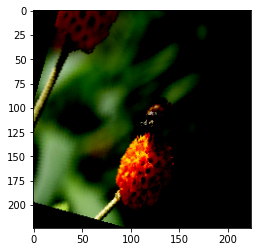

In [36]:
# (3, 224, 224) ==>> (224, 224, 3) for this we will use permute method
plt.imshow(img.permute(1,2,0))
plt.show()

## Download and use pre-trained model for transferlearning

In [37]:
model = models.alexnet(pretrained=True) #  Pre-Trained on Imagenet dataset over 1000

Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth


  0%|          | 0.00/233M [00:00<?, ?B/s]

In [38]:
print(model)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

## Count the no. of trainable parameters

In [39]:
def count_params(model):
  model_params = {"Modules": list(), "Parameters": list()}
  total = {"trainable": 0, "non_trainable": 0} 
  for name, parameters in model.named_parameters():
    param = parameters.numel()
    if not parameters.requires_grad:
      total["non_trainable"] += param
      continue
    model_params["Modules"].append(name)
    model_params["Parameters"].append(param)
    total["trainable"] += param
  df = pd.DataFrame(model_params)
  df = df.style.set_caption(f"Total parameters: {total}")
  return df

count_params(model)

,Modules,Parameters
0,features.0.weight,23232
1,features.0.bias,64
2,features.3.weight,307200
3,features.3.bias,192
4,features.6.weight,663552
5,features.6.bias,384
6,features.8.weight,884736
7,features.8.bias,256
8,features.10.weight,589824
9,features.10.bias,256


### Freeze all the layers

In [40]:
for parameters in model.parameters():
  parameters.requires_grad = False

In [41]:
count_params(model)

,Modules,Parameters


#### No parameter is trainable

In [42]:
## lets look at model classifier
model.classifier

Sequential(
  (0): Dropout(p=0.5, inplace=False)
  (1): Linear(in_features=9216, out_features=4096, bias=True)
  (2): ReLU(inplace=True)
  (3): Dropout(p=0.5, inplace=False)
  (4): Linear(in_features=4096, out_features=4096, bias=True)
  (5): ReLU(inplace=True)
  (6): Linear(in_features=4096, out_features=1000, bias=True)
)

### We will update model classifier according to our requirement:

In [43]:
model.classifier = nn.Sequential(
    nn.Linear(in_features=9216, out_features=100, bias=True),
    nn.ReLU(inplace=True),
    nn.Dropout(p=0.5, inplace=False),
    nn.Linear(in_features=100, out_features=2, bias=True)
)

In [ ]:
## Now lets take a look over the model
print(model)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Linear(in_features=9216, out_features=100, bias=True)
    (1): ReLU(inplace=True)
    (2): Drop

#### Again count the trainable and non-trainable parameters:

In [44]:
count_params(model)

,Modules,Parameters
0,classifier.0.weight,921600
1,classifier.0.bias,100
2,classifier.3.weight,200
3,classifier.3.bias,2


### Training loop

In [45]:
## Putting model over the device: cuda
model.to(config.DEVICE)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Linear(in_features=9216, out_features=100, bias=True)
    (1): ReLU(inplace=True)
    (2): Drop

In [46]:
## Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

In [47]:
for epoch in range(config.EPOCH):
  with tqdm(train_loader) as tqdm_epoch:
    for images, labels in tqdm_epoch:
      tqdm_epoch.set_description(f"Epoch {epoch + 1}/{config.EPOCH}")

      images = images.to(config.DEVICE)
      labels = labels.to(config.DEVICE)

      # forward pass
      outputs = model(images)
      loss = criterion(outputs, labels)

      # backward pass
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      tqdm_epoch.set_postfix(loss= loss.item())
      

Epoch 10/10: 100%|██████████| 8/8 [00:02<00:00,  3.10it/s, loss=0.0157]


In [48]:
os.makedirs("model_dir_2", exist_ok=True)
model_file_path = os.path.join("model_dir_2", "CNN_ALEXNET_model.pth")
torch.save(model, model_file_path)

## Evaluate our model

In [49]:
pred = np.array([])
target = np.array([])

with torch.no_grad():
  for batch, data in enumerate(test_loader):
    images = data[0].to(config.DEVICE)
    labels = data[1].to(config.DEVICE)

    y_pred = model(images)

    pred = np.concatenate((pred, torch.argmax(y_pred, 1).cpu().numpy()))
    target = np.concatenate((target, labels.cpu().numpy()))

In [50]:
cm = confusion_matrix(target, pred)

In [51]:
label_map

{'ants': 0, 'bees': 1}

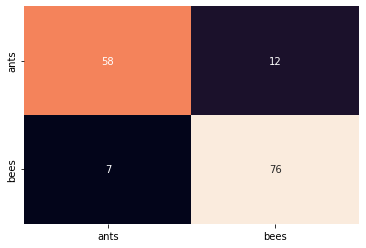

In [53]:
sns.heatmap(cm, annot=True, fmt='d', xticklabels=label_map.keys() , yticklabels=label_map.keys(), cbar=False)
plt.show()

## prediction on our model

In [54]:
data = next(iter(test_loader))
data

[tensor([[[[ 0.6078,  0.5765,  0.7176,  ...,  0.4275,  0.3490,  0.2784],
           [ 0.4667,  0.5373,  0.6078,  ...,  0.4353,  0.4353,  0.3176],
           [ 0.5294,  0.5529,  0.4902,  ...,  0.3569,  0.3569,  0.3569],
           ...,
           [ 0.0980,  0.3490,  0.6941,  ...,  0.2392,  0.2863,  0.6078],
           [ 0.2863,  0.4588,  0.6157,  ...,  0.0667,  0.1059,  0.1922],
           [ 0.2706,  0.3961,  0.5294,  ...,  0.0275,  0.2549,  0.0902]],
 
          [[ 0.9216,  0.8275,  0.8980,  ...,  0.7412,  0.5686,  0.4667],
           [ 0.8353,  0.8745,  0.8980,  ...,  0.7490,  0.6314,  0.4902],
           [ 0.8196,  0.8588,  0.7961,  ...,  0.6706,  0.6157,  0.6157],
           ...,
           [ 0.3255,  0.4510,  0.8588,  ...,  0.3569,  0.4196,  0.7255],
           [ 0.5686,  0.6000,  0.8118,  ...,  0.1843,  0.2392,  0.2549],
           [ 0.5059,  0.6314,  0.7961,  ...,  0.1294,  0.4196,  0.1529]],
 
          [[ 0.9843,  0.8902,  0.9216,  ...,  0.7961,  0.6549,  0.4275],
           [ 

In [55]:
## data contains image and image label
len(data)

2

In [56]:
## data contains image and image label
images, labels = data

In [57]:
images.shape, labels.shape

(torch.Size([32, 3, 224, 224]), torch.Size([32]))

In [58]:
## selected any random image: this time image at index number 2
img = images[2]

In [59]:
img.shape

torch.Size([3, 224, 224])

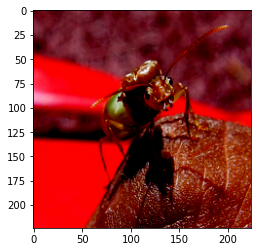

In [60]:
## visualize one image
plt.imshow(img.permute(1,2,0))

In [61]:
## unsqueeze operation to change image dimension
img.unsqueeze(0).shape

torch.Size([1, 3, 224, 224])

### Prediction Probability

In [62]:
## putting image over GPU
img_on_gpu = img.unsqueeze(0).to(config.DEVICE)

pred_prob = F.softmax(model(img_on_gpu), dim=1)
pred_prob

tensor([[0.5656, 0.4344]], device='cuda:0', grad_fn=<SoftmaxBackward0>)

In [63]:
## lets find index of heighest probability
argmax = torch.argmax(pred_prob).item()
argmax

0

In [64]:
inv_label_map = {val: key for key, val in label_map.items() }

inv_label_map

{0: 'ants', 1: 'bees'}

In [74]:
print(f"Actual label is: {inv_label_map[labels[2].item()]}\n")

print(f"Predicted label is: {inv_label_map[argmax]}")

Actual label is: ants

Predicted label is: ants


### Now lets make a function for prediction using all above steps:

In [75]:
def predict(data, model, label_map, device, idx=0):
  images, labels = data
  img = images[idx]
  label = labels[idx]

  plt.imshow(img.permute(1,2,0), cmap="gray")
  img_on_gpu = img.unsqueeze(0).to(config.DEVICE)

  pred_prob = F.softmax(model(img_on_gpu), dim=1)
  argmax = torch.argmax(pred_prob).item()
  
  predicted_label = label_map[argmax]
  actual_label = label_map[label.item()]

  plt.title(f"actual: {actual_label} | predicted: {predicted_label}")
  plt.axis("off")
  return predicted_label, actual_label


('ants', 'ants')

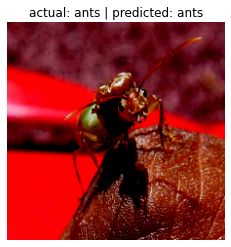

In [76]:
predict(data, model, inv_label_map, config.DEVICE, idx=2)